# CSC413 Resnet

## Data loading and resize


In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

from PIL import Image
import matplotlib.pyplot as plt
import time
import os


In [2]:

import torch.cuda
torch.cuda.is_available()

print(torch.__version__)

import torch.cuda
torch.cuda.is_available()


2.0.0+cu118


True

In [3]:
#download data from https://www.kaggle.com/competitions/dog-breed-identification/data, change the following path to your own data locations
TRAIN_IMG_PATH = "C:/Users/sunya/Downloads/dog-breed-identification/train"
TEST_IMG_PATH = "C:/Users/sunya/Downloads/dog-breed-identification/test"
LABELS_CSV_PATH = "C:/Users/sunya/Downloads/dog-breed-identification/labels.csv"
SAMPLE_SUB_PATH = "C:/Users/sunya/Downloads/dog-breed-identification/sample_submission.csv"

In [4]:
# define class to read data
class DogsDataset(Dataset):
    """Dog breed identification dataset."""

    def __init__(self, img_dir, dataframe, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.        
            dataframe (pandas.core.frame.DataFrame): Pandas dataframe obtained
                by read_csv().
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels_frame.id[idx]) + ".jpg"
        image = Image.open(img_name)
        label = self.labels_frame.target[idx]

        if self.transform:
            image = self.transform(image)

        return [image, label] 

### Instantiate the class and show the first images and sizes.

cairn
Shape of the image is:  (500, 375)


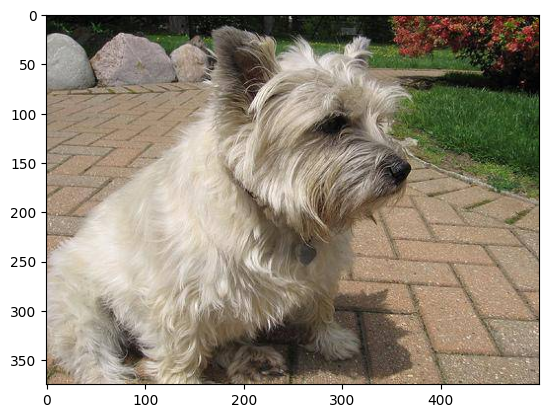

In [5]:
# data set reading and preview
dframe = pd.read_csv(LABELS_CSV_PATH)
labelnames = pd.read_csv(SAMPLE_SUB_PATH).keys()[1:]
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
dframe['target'] =  [breed_to_code[x] for x in dframe.breed]

cut = int(len(dframe)*0.8)
train, test = np.split(dframe, [cut], axis=0)
test = test.reset_index(drop=True)

train_ds = DogsDataset(TRAIN_IMG_PATH, train)
test_ds = DogsDataset(TRAIN_IMG_PATH, test)
idx = 29
plt.imshow(train_ds[idx][0])
print(code_to_breed[train_ds[idx][1]])
print("Shape of the image is: ", train_ds[idx][0].size)

### Reshape the images

In [6]:
# reshape images and prepare data for model training
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_transformer = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.RandomRotation(15),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transformer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [7]:
train_ds = DogsDataset(TRAIN_IMG_PATH, train, train_transformer)
test_ds = DogsDataset(TRAIN_IMG_PATH, test, val_transformer)
datasets = {"train": train_ds, "val": test_ds}

idx = 29
print(code_to_breed[train_ds[idx][1]])
print("Shape of the image is: ", train_ds[idx][0].shape)

cairn
Shape of the image is:  torch.Size([3, 224, 224])


In [8]:
trainloader = DataLoader(train_ds, batch_size=64,
                        shuffle=True)

testloader = DataLoader(test_ds, batch_size=64,
                        shuffle=True)

dataloaders = {"train": trainloader, "val": testloader}

In [9]:
# Use resnet-50 as a base model
class net(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = nn.functional.relu(self.base_model(x))
        x = nn.functional.relu(self.linear1(x))
        x = self.output(x)
        return x



In [36]:
import pytorch_lightning
import torchmetrics
# Print the result of 1 epoch

def print_epoch_result(train_loss,train_acc,val_loss,val_acc):
    print('loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}'.format(train_loss,
                                                                              train_acc,
                                                                              val_loss,
                                                                              val_acc))
# Main Training function
def train_model(model, cost_function, optimizer,num_epochs=5):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    # Metrics object
    train_acc_object = torchmetrics.Accuracy(task="multiclass", num_classes=120)
    val_acc_object = torchmetrics.Accuracy(task="multiclass", num_classes=120)

    for epoch in range(num_epochs):
        """
        On epoch start
        """
        print('-'*15)
        print('Start training {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)

        # Training
        train_sub_losses = []
        model.train()
        for x,y in trainloader:
            optimizer.zero_grad()
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            # update loss sublist
            train_sub_losses.append(loss.item())
            # update accuracy object
            train_acc_object(y_hat.cpu(),y.cpu())

        # Validation
        val_sub_losses = []
        model.eval()
        for x,y in testloader:
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            val_sub_losses.append(loss.item())
            val_acc_object(y_hat.cpu(),y.cpu())

        """
        On epoch end
        """
        # Update the loss list
        train_losses.append(np.mean(train_sub_losses))
        val_losses.append(np.mean(val_sub_losses))

        # Update the accuracy list and reset the metrics object
        train_epoch_acc = train_acc_object.compute()
        val_epoch_acc = val_acc_object.compute()
        train_acc.append(train_epoch_acc)
        val_acc.append(val_epoch_acc)
        train_acc_object.reset()
        val_acc_object.reset()

        # print the result of epoch
        print_epoch_result(np.mean(train_sub_losses),train_epoch_acc,np.mean(val_sub_losses),val_epoch_acc)

    print('Finish Training.')
    return train_losses, train_acc, val_losses, val_acc

In [15]:
# train ResNet_50 pretrained model and print out the result
res_50 = models.resnet50(weights = "DEFAULT")
for param in res_50.parameters():
    param.requires_grad=False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_50 = net(base_model=res_50, base_out_features=res_50.fc.out_features, num_classes=120)
model_50 = model_50.to(device)

# Cost function and optimzier
cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model_50.parameters() if param.requires_grad], lr=0.0003)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Epoch
EPOCHS = 30
train_losses_50, train_acc_50, val_losses_50, val_acc_50 = train_model(model=model_50,
                                                           cost_function=cost_function,
                                                           optimizer=optimizer,
                                                           num_epochs=EPOCHS)

---------------
Start training 1/30
---------------
loss: 3.733, acc: 0.328, val_loss: 2.087, val_acc: 0.715
---------------
Start training 2/30
---------------
loss: 1.930, acc: 0.599, val_loss: 0.987, val_acc: 0.807
---------------
Start training 3/30
---------------
loss: 1.438, acc: 0.665, val_loss: 0.707, val_acc: 0.833
---------------
Start training 4/30
---------------
loss: 1.293, acc: 0.682, val_loss: 0.599, val_acc: 0.851
---------------
Start training 5/30
---------------
loss: 1.216, acc: 0.690, val_loss: 0.559, val_acc: 0.856
---------------
Start training 6/30
---------------
loss: 1.138, acc: 0.709, val_loss: 0.529, val_acc: 0.844
---------------
Start training 7/30
---------------
loss: 1.120, acc: 0.704, val_loss: 0.485, val_acc: 0.857
---------------
Start training 8/30
---------------
loss: 1.087, acc: 0.717, val_loss: 0.481, val_acc: 0.861
---------------
Start training 9/30
---------------
loss: 1.055, acc: 0.722, val_loss: 0.458, val_acc: 0.866
---------------
Sta

In [11]:
# train ResNet_34 pretrained model and print out the result
res_34 = models.resnet34(weights = "DEFAULT")
for param in res_34.parameters():
    param.requires_grad=False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_34 = net(base_model=res_34, base_out_features=res_34.fc.out_features, num_classes=120)
model_34 = model_34.to(device)

# Cost function and optimzier
cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model_34.parameters() if param.requires_grad], lr=0.0003)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Epoch
EPOCHS = 30
train_losses_34, train_acc_34, val_losses_34, val_acc_34 = train_model(model=model_34,
                                                           cost_function=cost_function,
                                                           optimizer=optimizer,
                                                           num_epochs=EPOCHS)

---------------
Start training 1/30
---------------
loss: 3.101, acc: 0.336, val_loss: 1.295, val_acc: 0.687
---------------
Start training 2/30
---------------
loss: 1.733, acc: 0.570, val_loss: 0.845, val_acc: 0.759
---------------
Start training 3/30
---------------
loss: 1.506, acc: 0.600, val_loss: 0.741, val_acc: 0.783
---------------
Start training 4/30
---------------
loss: 1.376, acc: 0.626, val_loss: 0.685, val_acc: 0.797
---------------
Start training 5/30
---------------
loss: 1.349, acc: 0.641, val_loss: 0.666, val_acc: 0.800
---------------
Start training 6/30
---------------
loss: 1.312, acc: 0.647, val_loss: 0.655, val_acc: 0.799
---------------
Start training 7/30
---------------
loss: 1.275, acc: 0.661, val_loss: 0.638, val_acc: 0.803
---------------
Start training 8/30
---------------
loss: 1.248, acc: 0.668, val_loss: 0.643, val_acc: 0.796
---------------
Start training 9/30
---------------
loss: 1.215, acc: 0.672, val_loss: 0.631, val_acc: 0.800
---------------
Sta

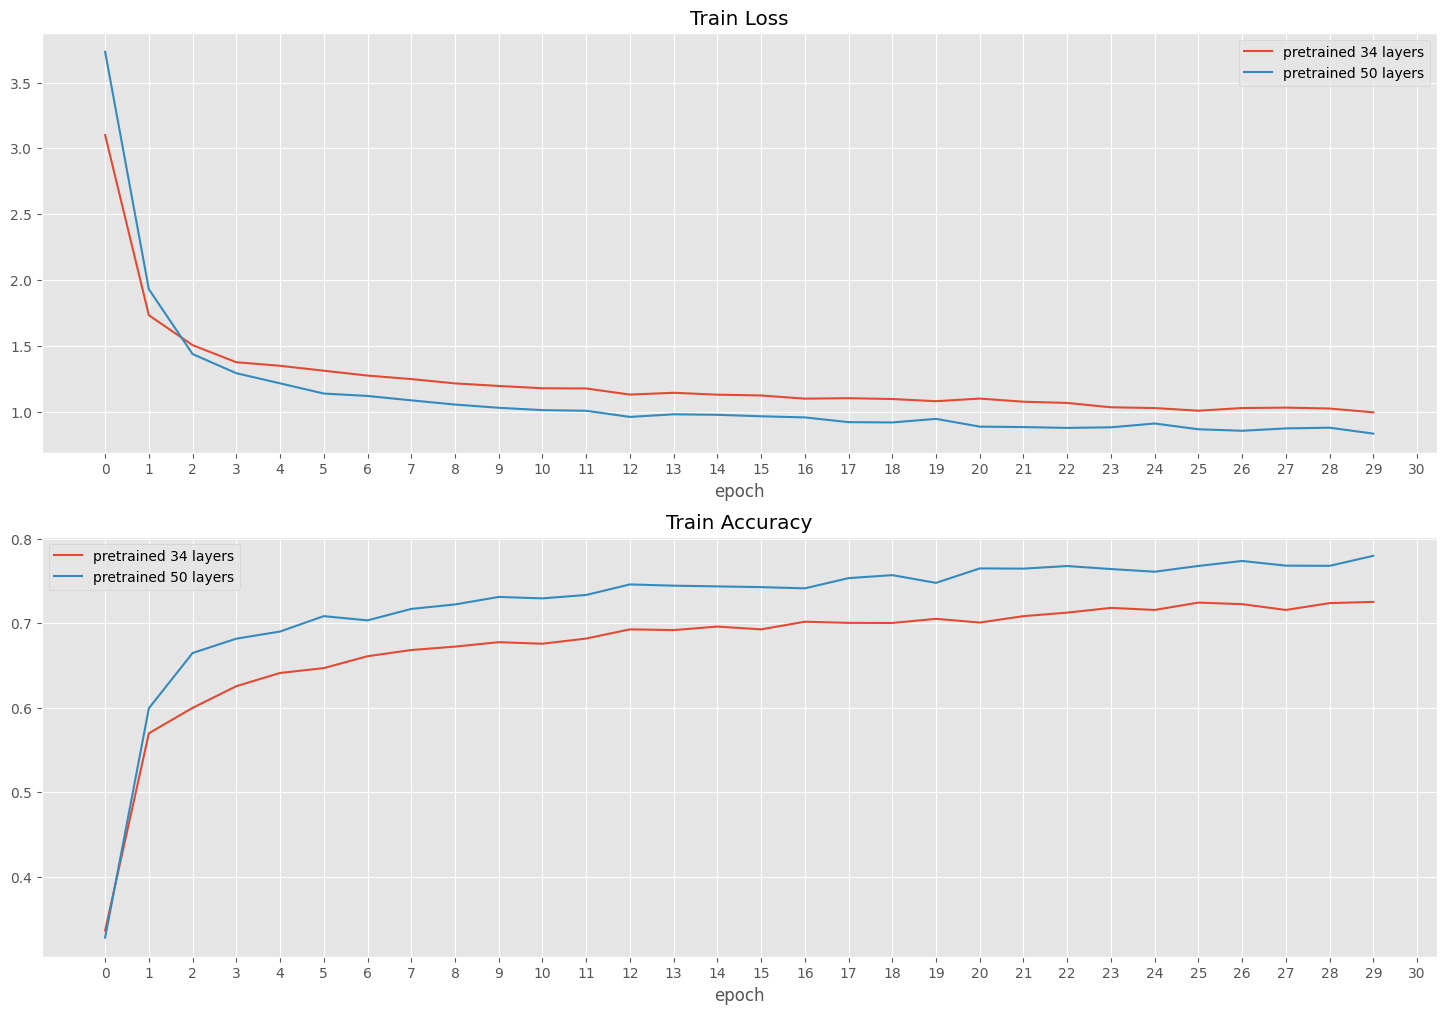

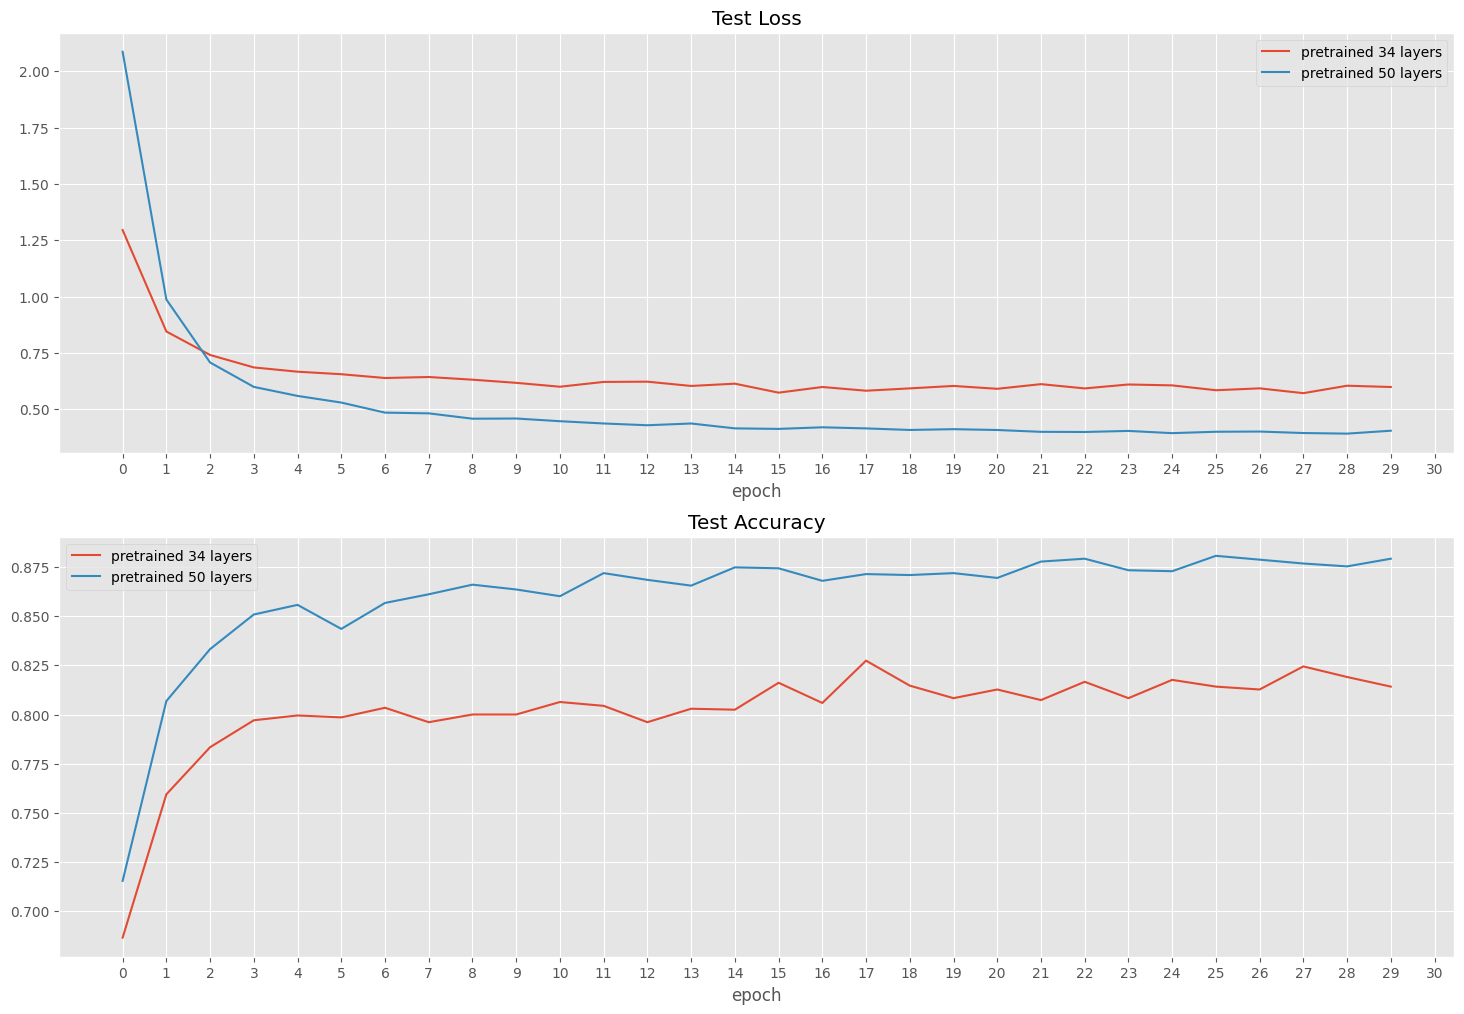

In [53]:
# plot the training and validation losses
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(18,12))
ax1.plot(train_losses_34,label='pretrained 34 layers')
ax1.plot(train_losses_50,label='pretrained 50 layers')
ax1.legend()
ax1.set_title("Train Loss")
ax1.set_xlabel('epoch')
ax1.set_xticks(range(0,EPOCHS+1))
ax2.plot(train_acc_34,label='pretrained 34 layers')
ax2.plot(train_acc_50,label='pretrained 50 layers')
ax2.legend()
ax2.set_title("Train Accuracy")
ax2.set_xlabel('epoch')
ax2.set_xticks(range(0,EPOCHS+1))
fig, (ax3, ax4) = plt.subplots(nrows=2,ncols=1,figsize=(18,12))
ax3.plot(val_losses_34,label='pretrained 34 layers')
ax3.plot(val_losses_50,label='pretrained 50 layers')
ax3.legend()
ax3.set_title("Test Loss")
ax3.set_xlabel('epoch')
ax3.set_xticks(range(0,EPOCHS+1))
ax4.plot(val_acc_34,label='pretrained 34 layers')
ax4.plot(val_acc_50,label='pretrained 50 layers')
ax4.legend()
ax4.set_title("Test Accuracy")
ax4.set_xlabel('epoch')
ax4.set_xticks(range(0,EPOCHS+1))
plt.show()
